In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid",{'axes.grid' : False})
from BayesianNeuralNetwork import *
from HiPMDP import HiPMDP
from __future__ import print_function
from ExperienceReplay import ExperienceReplay
from multiprocessing import Pool

## Generate batch of transition data
* Toy domain
* 2 different task instances
* Agent learning model-free using e-greedy policy based on DQN


In [2]:
domain = 'grid'
run_type = 'modelfree'
preset_hidden_params = [{'latent_code':1},{'latent_code':2}]
ddqn_learning_rate = 0.0005
episode_count = 500
bnn_hidden_layer_size = 25
bnn_num_hidden_layers = 3
bnn_network_weights = None
eps_min = 0.15
test_inst = None
create_exp_batch = True
state_diffs = True
grid_beta = 0.1
batch_generator_hipmdp = HiPMDP(domain,preset_hidden_params,
                                ddqn_learning_rate=ddqn_learning_rate,
                                episode_count=episode_count,
                                run_type=run_type, eps_min=eps_min,
                                create_exp_batch=create_exp_batch,grid_beta=grid_beta,
                                print_output=True)

In [ ]:
(exp_buffer, networkweights, rewards, avg_rwd_per_ep, full_task_weights,
     sys_param_set, mean_episode_errors, std_episode_errors) = batch_generator_hipmdp.run_experiment()

In [4]:
with open('results/{}_exp_buffer'.format(domain),'w') as f:
    pickle.dump(exp_buffer,f)

In [3]:
# with open('results/{}_exp_buffer'.format(domain),'r') as f:
#      exp_buffer = pickle.load(f)

#### Reformat Data

In [5]:
# Create numpy array 
exp_buffer_np = np.vstack(exp_buffer)
# Collect the instances that each transition came from
inst_indices = exp_buffer_np[:,4]
inst_indices = inst_indices.astype(int)
# Group experiences by instance
# Create dictionary where keys are instance indexes and values are np.arrays experiences
exp_dict = {}
for idx in xrange(batch_generator_hipmdp.instance_count):
    exp_dict[idx] = exp_buffer_np[inst_indices == idx]
X = np.array([np.hstack([exp_buffer_np[tt,0],exp_buffer_np[tt,1]]) for tt in range(exp_buffer_np.shape[0])])
y = np.array([exp_buffer_np[tt,3] for tt in range(exp_buffer_np.shape[0])])
num_dims = 2
num_actions = 4
num_wb = 5
if state_diffs:
    # subtract previous state
    y -= X[:,:num_dims]

## Train BNN and learn latent weights using batch data

#### Set up BNN and latent weights

In [6]:
relu = lambda x: np.maximum(x, 0.)
param_set = {
    'bnn_layer_sizes': [num_dims+num_actions+num_wb]+[bnn_hidden_layer_size]*bnn_num_hidden_layers+[num_dims],
    'weight_count': num_wb,
    'num_state_dims': num_dims,
    'bnn_num_samples': 50,
    'bnn_batch_size': 32,
    'num_strata_samples': 5,
    'bnn_training_epochs': 1,
    'bnn_v_prior': 1.0,
    'bnn_learning_rate': 0.00005,
    'bnn_alpha':0.5,
    'wb_num_epochs':1,
    'wb_learning_rate':0.0005
}
# Initialize latent weights for each instance
full_task_weights = np.random.normal(0.,0.1,(batch_generator_hipmdp.instance_count,num_wb))
# Initialize BNN
network = BayesianNeuralNetwork(param_set, nonlinearity=relu)

In [7]:
# Compute error before training
l2_errors = network.get_td_error(np.hstack((X,full_task_weights[inst_indices])), y, location=0.0, scale=1.0, by_dim=False)
print ("Before training: Mean Error: {}, Std Error: {}".format(np.mean(l2_errors),np.std(l2_errors)))
np.mean(l2_errors),np.std(l2_errors)
print ("L2 Difference in latent weights between instances: {}".format(np.sum((full_task_weights[0]-full_task_weights[1])**2)))

Before training: Mean Error: 0.3252623305, Std Error: 0.105944330689
L2 Difference in latent weights between instances: 0.11411991762


#### Oscillate between training BNN and latent weights

In [8]:
def get_random_sample(start,stop,size):
    indices_set = set()
    while len(indices_set) < size:
        indices_set.add(np.random.randint(start,stop))
    return np.array(list(indices_set))

In [ ]:
# size of sample to compute error on
sample_size = 10000
for i in xrange(40):    
    # Update BNN network weights
    network.fit_network(exp_buffer_np, full_task_weights, 0, state_diffs=state_diffs,
                        use_all_exp=True)
    print('finished BNN update '+str(i))
    if i % 4 == 0:
        #get random sample of indices
        sample_indices = get_random_sample(0,X.shape[0],sample_size)
        l2_errors = network.get_td_error(np.hstack((X[sample_indices],full_task_weights[inst_indices[sample_indices]])), y[sample_indices], location=0.0, scale=1.0, by_dim=False)
        print ("After BNN update: iter: {}, Mean Error: {}, Std Error: {}".format(i,np.mean(l2_errors),np.std(l2_errors)))
    # Update latent weights
    for inst in np.random.permutation(batch_generator_hipmdp.instance_count):
        full_task_weights[inst,:] = network.optimize_latent_weighting_stochastic(
            exp_dict[inst],np.atleast_2d(full_task_weights[inst,:]),0,state_diffs=state_diffs,use_all_exp=True)
    print ('finished wb update '+str(i))
    # Compute error on sample of transitions
    if i % 4 == 0:
        #get random sample of indices
        sample_indices = get_random_sample(0,X.shape[0],sample_size)
        l2_errors = network.get_td_error(np.hstack((X[sample_indices],full_task_weights[inst_indices[sample_indices]])), y[sample_indices], location=0.0, scale=1.0, by_dim=False)
        print ("After Latent update: iter: {}, Mean Error: {}, Std Error: {}".format(i,np.mean(l2_errors),np.std(l2_errors)))
        print ("L2 Difference in latent weights between instances: {}".format(np.sum((full_task_weights[0]-full_task_weights[1])**2)))

In [10]:
network_weights = network.weights

In [ ]:
with open('results/{}_network_weights'.format(domain), 'w') as f:
    pickle.dump(network.weights, f)
# with open('results/{}_network_weights'.format(domain), 'r') as f:
#     network_weights = pickle.load(f)

## Learn dynamics and policy for new instance using HiP-MDP with embedded latent weights

In [ ]:
results = {}
run_type = 'full'
create_exp_batch = False
episode_count = 20 # reduce episode count for demonstration since HiPMDP learns policy quickly
for run in xrange(5):
    for test_inst in [0,1]:
        test_hipmdp = HiPMDP(domain,preset_hidden_params, 
                         ddqn_learning_rate=ddqn_learning_rate, 
                         episode_count=episode_count,
                         run_type=run_type,
                         bnn_hidden_layer_size=bnn_hidden_layer_size,
                         bnn_num_hidden_layers=bnn_num_hidden_layers,
                         bnn_network_weights=network_weights, test_inst=test_inst,
                         eps_min=eps_min, create_exp_batch=create_exp_batch,grid_beta=grid_beta,print_output=True)
        results[(test_inst,run)] = test_hipmdp.run_experiment()
        with open('results/{}_results'.format(domain),'w') as f:
            pickle.dump(results,f)

In [3]:
# with open('results/{}_results'.format(domain),'r') as f:
#     results = pickle.load(f)

## Plot Results

In [4]:
# Group rewards, errors by instance
reward_key = 'Reward'
error_key = 'BNN Error'
clean_results = {(0,reward_key):[],(0,error_key):[],(1,reward_key):[],(1,error_key):[]}
for test_inst in [0,1]:
    for run in xrange(5):
        clean_results[(test_inst,reward_key)].append(results[(test_inst,run)][2])
        clean_results[(test_inst,error_key)].append(results[(test_inst,run)][6])
    clean_results[(test_inst,reward_key)] = np.vstack(clean_results[(test_inst,reward_key)])
    clean_results[(test_inst,error_key)] = np.vstack(clean_results[(test_inst,error_key)])


In [5]:
def plot_results(clean_results, test_inst):
    f, ax_array = plt.subplots(2,figsize=(7,7))
    result_names = [reward_key,error_key]
    for result_idx in xrange(2):
        result = result_names[result_idx]
        mean_result = np.mean(clean_results[(test_inst,result)], axis=0)
        std_result = np.std(clean_results[(test_inst,result)], axis=0)
        ax_array[result_idx].errorbar(x=np.arange(len(mean_result)),y=mean_result,yerr=std_result)
        _ = ax_array[result_idx].set_ylim((np.min(mean_result)-0.01,np.max(mean_result)+0.01))
        ax_array[result_idx].set_ylabel(result)
    ax_array[1].set_xlabel("Episode")
    f.suptitle("Full HiP-MDP Training Results Instance {}".format(test_inst),fontsize=12)

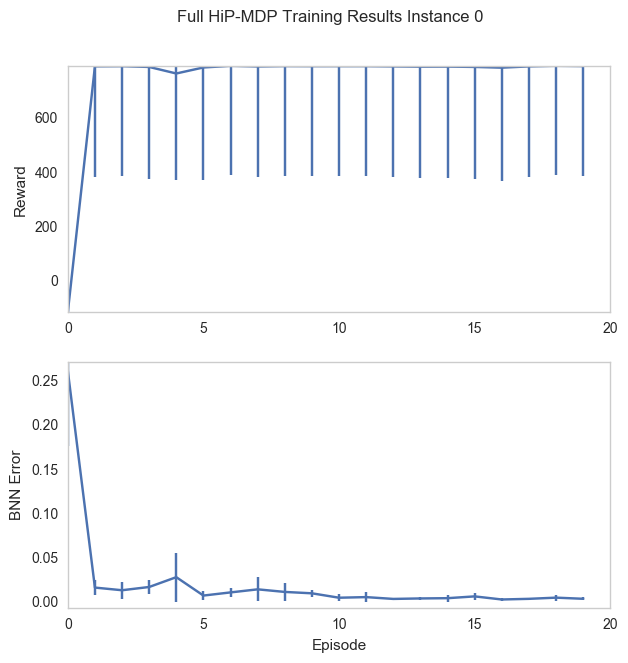

In [6]:
plot_results(clean_results, 0)

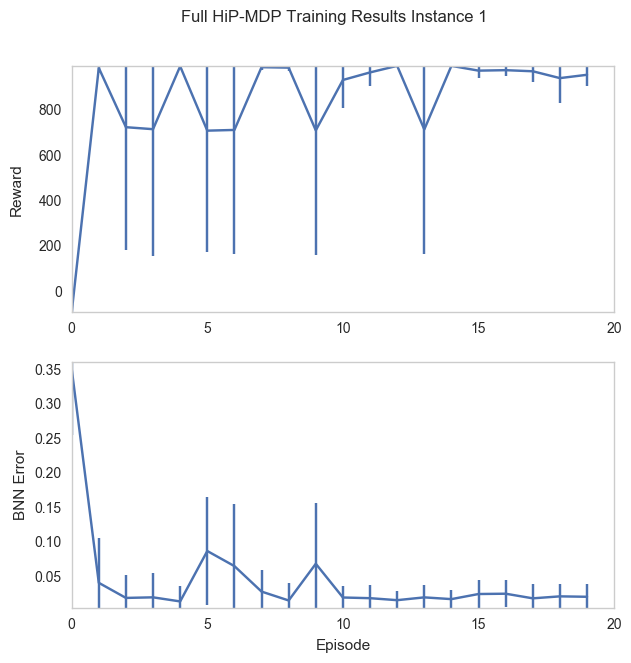

In [7]:
plot_results(clean_results, 1)